In [1]:


import os
import tempfile
from glob import glob
import shutil

import matplotlib.pyplot as plt
import monai
import nibabel as nib
import numpy as np
import torch
from monai.data import DataLoader, create_test_image_3d
from monai.inferers import SliceInferer
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    RandRotate90d,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
)
from monai.visualize import matshow3d

monai.config.print_config()
monai.utils.set_determinism(0)



2023-10-04 14:54:24.468406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


MONAI version: 1.2.0
Numpy version: 1.23.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.14.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:

In [2]:


directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpe_08cjap


In [3]:
#generating synthetic data
for i in range(40):
    H, W, D = 30 + i, 40 + i, 50 + i
    im, seg = create_test_image_3d(H,W,D, num_seg_classes=1, channel_dim=-1, rad_max=10)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n,os.path.join(root_dir, f"img{i:d}.nii.gz"))
    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir,f"seg{i:d}.nii.gz"))

images = sorted(glob(os.path.join(root_dir, "img*.nii.gz")))
segs = sorted(glob(os.path.join(root_dir, "seg*.nii.gz")))

In [6]:
train_files = [{"img":img, "seg":seg} for img, seg in zip(images[:35], segs[:35])]
val_files = [{"img":img, "seg":seg} for img, seg in zip(images[-3:], segs[-3:])]

In [8]:
#volume transforms for both volume and labels
img_seg = ("img","seg")
train_transforms = Compose(
    [
        LoadImaged(img_seg),
        EnsureChannelFirstd(img_seg),
        ScaleIntensityd(img_seg),
        RandRotate90d(img_seg),
        EnsureTyped(img_seg)
    ]
)

#cache dataset with the transforms 
volume_ds = monai.data.CacheDataset(data = train_files, transform=train_transforms)

check_loader = DataLoader(volume_ds, batch_size = 1)
check_data = monai.utils.misc.first(check_loader)
print("first volume shape", check_data["img"].shape, check_data["seg"].shape)

/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 35/35 [00:00<00:00, 125.52it/s]

first volume shape torch.Size([1, 1, 30, 40, 50]) torch.Size([1, 1, 30, 40, 50])


In [14]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"], patch_size=(None, None, 1), start_pos=(0, 0, 0)  # dynamic first two dimensions
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        Resized(keys=["img", "seg"], spatial_size=[48, 48]),
        # to use crop/pad instead of resize:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_ds = monai.data.GridPatchDataset(
    data=volume_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False
)
shuffle_ds = monai.data.ShuffleBuffer(patch_ds, buffer_size=30, seed=0)
train_loader = DataLoader(
    shuffle_ds,
    batch_size=5,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["img"].shape, check_data["seg"].shape)

first patch's shape:  torch.Size([5, 1, 48, 48]) torch.Size([5, 1, 48, 48])


In [18]:
#define the 2D networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims = 2,
    in_channels=1,
    out_channels=1,
    channels=(16,32,64,128),
    strides=(2,2,2),
    num_res_units=2
).to(device)

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-3)

In [19]:


epoch_loss_values = []
num_epochs = 5
for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 200 == 0:
            print(f"{step}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
print("train completed")

----------
epoch 1/5
200, train_loss: 0.6679
epoch 1 average loss: 0.5702
----------
epoch 2/5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb6bd2e8ae0>
Traceback (most recent call last):
  File "/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb6bd2e8ae0>^
^Traceback (most recent call last):
^  File "/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/torch/utils/data/dat

200, train_loss: 0.3120
epoch 2 average loss: 0.2819
----------
epoch 3/5
200, train_loss: 0.2988
epoch 3 average loss: 0.2667
----------
epoch 4/5
200, train_loss: 0.2962
epoch 4 average loss: 0.2629
----------
epoch 5/5
200, train_loss: 0.2960
epoch 5 average loss: 0.2617
train completed


/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Dice:  tensor(0.9941)


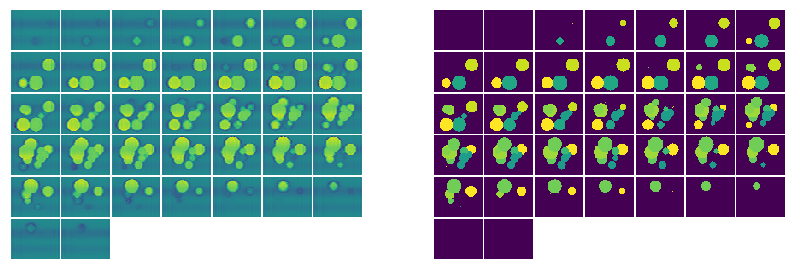

Dice:  tensor(0.9935)


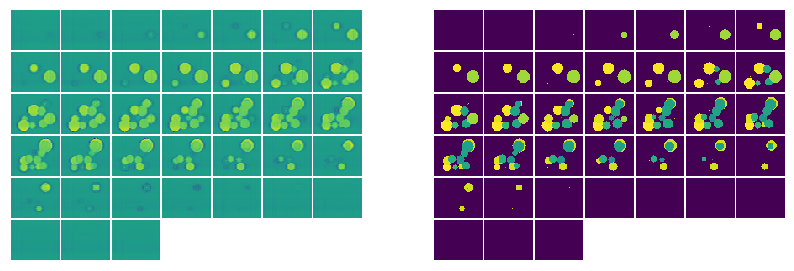

Dice:  tensor(0.9914)


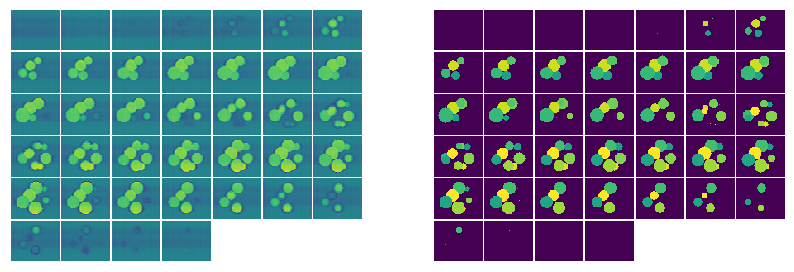

Avg Dice: 0.9930039048194885


In [21]:
#using slice inferer

val_transform = Compose([
    LoadImaged(img_seg),
    EnsureChannelFirstd(img_seg),
    ScaleIntensityd(img_seg),
    EnsureTyped(img_seg)
])

val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
data_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.eval()

with torch.no_grad():
    for val_data in data_loader:
        val_images = val_data["img"].to(device)
        roi_size = (48,48)
        sw_batch_size = 3
        slice_inferer = SliceInferer(
            roi_size=roi_size,
            sw_batch_size= sw_batch_size,
            spatial_dim=1,
            device = torch.device('cpu'),
            padding_mode = "replicate"
        )
        val_output = slice_inferer(val_images, model).to('cpu')
        dice_metric(y_pred=val_output>0.5, y=val_data["seg"])
        print("Dice: ", dice_metric.get_buffer()[-1][0])
        fig = plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        matshow3d(val_output[0], fig=plt.gca())
        plt.subplot(1, 2, 2)
        matshow3d(val_images[0], fig=plt.gca())
        plt.show()
    print(f"Avg Dice: {dice_metric.aggregate().item()}")



In [22]:
val_output.shape

torch.Size([1, 1, 39, 49, 59])